In [ ]:
- classification : 이미지를 분류
- Detection : 이미지를 분류만이 아니라 어느 위치에 있는지 탐지
- Segmentation : 이미지를 분할

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. ImageDataGenerator

- 원본 이미지에 적절한 변형을 가해서 새로운 데이터를 만드는 방식
- 텐서플로우에서는 이미지 데이터 보강을 위해 ImageDataGenerator 제공


    tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        brightness_range=None,
        shear_range=0.0,
        zoom_range=0.0,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=False,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0,
        interpolation_order=1,
        dtype=None
    )



- 하나의 상위 폴더 아래에 레이블을 이름으로 하는 각각의 하위폴더들이 준비되어 있어야 한다
- 각각의 데이터는 정답 데이터로된 폴더로 묶여있어야 한다.
- flow_from_directory()

In [5]:
with zipfile.ZipFile("data/test_img_dir.zip") as target_file:
    target_file.extractall("data/")

In [6]:
gen = ImageDataGenerator(rotation_range=10, shear_range=0.2,
                         horizontal_flip=True, rescale = 1./255)

# rescale = 정규화를 대신 해줌
# rescale 이외에는 실행이 될수도 안될수도 있다. 난수에 따라 랜덤으로 적용

In [22]:
# data_gen = gen.flow_from_directory(directory="data/test_img_dir", batch_size=4,
#                         shuffle=True,target_size=(100, 100),
#                        class_mode = "categorical")
data_gen = gen.flow_from_directory(directory="data/test_img_dir", batch_size=4,
                        shuffle=True,target_size=(100, 100),
                       class_mode = "sparse")

Found 12 images belonging to 3 classes.


In [13]:
?gen.flow_from_directory

Object `gen.flow_from_directory` not found.


In [24]:
print(data_gen.class_indices)
print(data_gen.num_classes)
print(data_gen.class_mode)

{'cat': 0, 'deer': 1, 'dog': 2}
3
sparse


label=> 2.0
label=> 1.0
label=> 1.0
label=> 2.0


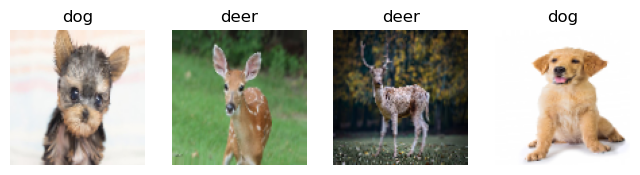

In [26]:
# batch_size에 맞춰서 가져온다
# 한번에 몇개를 가져올 것인가?
img, label = data_gen.next()

# 결과표의 이름을 label명으로 나오게 바꿔주자
class_names = {0:"cat", 1:"deer", 2:"dog"}

for i in range(len(label)):
    print("label=>", label[i])
    
plt.figure(figsize=(8,8))
for i in range(len(img)):
    plt.subplot(1, len(img), i+1)
    plt.title(class_names[int(label[i])])
    plt.imshow(img[i])
    plt.axis('off')

# 2. Cats and Dogs

In [70]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

train_data_gen = ImageDataGenerator(rotation_range=10,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    rescale = 1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1)

# test_data에는 정규화만 적용해준다
test_data_gen = ImageDataGenerator(rescale = 1./255)

train_dir = "content/cats_and_dogs_filtered/train"
test_dir = "content/cats_and_dogs_filtered/validation"

train_data = gen.flow_from_directory(directory=train_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "sparse")

test_data = gen.flow_from_directory(directory=test_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "sparse")

print(train_data.class_indices)
print(train_data.num_classes)


print(test_data.class_indices)
print(test_data.num_classes)




base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3))

# include_top = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation="softmax"))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), metrics=['acc'])


start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=16, validation_data=test_data)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

model.evaluate(test_data)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 50176)             0         
                                                                 
 dense_30 (Dense)            (None, 16)                802832    
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_31 (Dense)            (None, 2)                 34        
                                                   

[0.07249617576599121, 0.972000002861023]

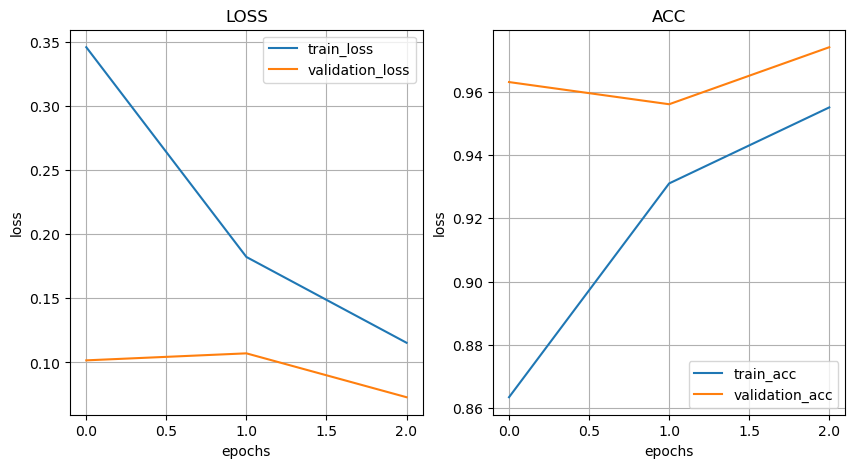

In [72]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

## 테스트 이미지 확인

- 텐서플로우를 사용 못하는 환경에서는 cv2를 사용하자

In [73]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
    
# with zipfile.ZipFile("/content/cats_and_dogs_filtered.zip", "r") as target_file:
#     target_file.extractall("/content/")

##### 이진분류

##### 데이터 갯수 확인


cats_train_list = os.listdir("content/cats_and_dogs_filtered/train/cats")
dogs_train_list = os.listdir("content/cats_and_dogs_filtered/train/dogs")

cats_val_list = os.listdir("content/cats_and_dogs_filtered/validation/cats")
dogs_val_list = os.listdir("content/cats_and_dogs_filtered/validation/dogs")

print(len(cats_train_list), len(dogs_train_list))
print(len(cats_val_list), len(dogs_val_list))

image_list = []
label_list = []

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

train_base_dir = "content/cats_and_dogs_filtered/train"
train_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for train_label_name in train_label_list:
    if train_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(train_base_dir, train_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_train = np.array(image_list).astype("float32")
y_train = np.array(label_list).astype("float32")
print(X_train.shape, y_train.shape)

image_list = []
label_list = []



val_base_dir = "content/cats_and_dogs_filtered/validation"
val_label_list = os.listdir(train_base_dir)

start_time = datetime.now()

for val_label_name in val_label_list:
    if val_label_name == "cats":
        label_num = 0.0
    else:
        label_num = 1.0
    
    file_path = os.path.join(val_base_dir, val_label_name)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT,IMAGE_WIDTH))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        image_list.append(src_img)
        label_list.append(label_num)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

X_val = np.array(image_list).astype("float32")
y_val = np.array(label_list).astype("float32")

print(X_val.shape, y_val.shape)

s = np.arange(len(X_val))
np.random.shuffle(s)

X_val = X_val[s]
y_val = y_val[s]

split_num = int(0.5 * len(X_val))

X_test = X_val[0:split_num]
y_test = y_val[0:split_num]

X_val = X_val[split_num:]
y_val = y_val[split_num:]


print(X_val.shape, X_test.shape)
print(y_val.shape, y_test.shape)

# 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3))

# include_top = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), metrics=['acc'])


start_time = datetime.now()

result = model.fit(X_train, y_train,
                 epochs=3, batch_size=16, 
                 validation_data=(X_val, y_val))

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

model.evaluate(X_test, y_test)

1000 1000
500 500

걸린시간 :  0:00:03.314091
(2000, 224, 224, 3) (2000,)

걸린시간 :  0:00:01.621561
(1000, 224, 224, 3) (1000,)
(500, 224, 224, 3) (500, 224, 224, 3)
(500,) (500,)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 50176)             0         
                                                                 
 dense_32 (Dense)            (None, 16)                802832    
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
           

[0.05124571546912193, 0.984000027179718]

In [74]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

test_img_list = []

test_img_name_list = glob.glob("data/test_dir/*")

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=[IMAGE_WIDTH, IMAGE_HEIGHT])
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img/255.0
    test_img_list.append(dst_img)
    
print(test_img_list)

[array([[[0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        ...,
        [0.55294118, 0.43921569, 0.28235294],
        [0.56078431, 0.43921569, 0.28627451],
        [0.56470588, 0.43921569, 0.28627451]],

       [[0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        ...,
        [0.55294118, 0.43529412, 0.28235294],
        [0.56078431, 0.43529412, 0.28235294],
        [0.56470588, 0.43137255, 0.28235294]],

       [[0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        ...,
        [0.55294118, 0.43137255, 0.27843137],
        [0.56078431, 0.43137255, 0.27843137],
        [0.56470588, 0.42745098, 0.27843137]],

       ...,

       [[0.80392157, 0.78039216, 0.73333333],
        [0.78431373, 0.76078431, 0.71372549],
        [0.75294118, 

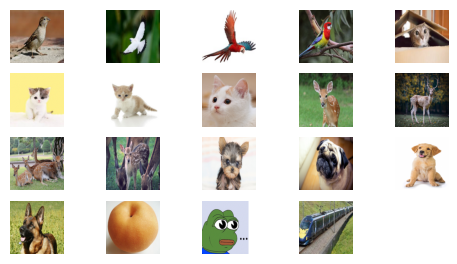

In [75]:
plt.figure(figsize=(6, 4))

for i in range(len(test_img_list)):
    plt.subplot(5, 5, i+1)
    plt.axis("off")
    plt.imshow(test_img_list[i])

In [76]:
test_img_list[0].shape
# (224, 224, 3)
# 현재 3차원

(224, 224, 3)

In [77]:
np.array(test_img_list).shape
# (19, 224, 224, 3)
# 배열로 감싸니 4차원

(19, 224, 224, 3)

In [78]:
pred = model.predict(np.array(test_img_list))

1/1 [==============================] - 1s 562ms/step


In [79]:
print(pred.shape)
print(pred)

(19, 1)
[[9.6500397e-01]
 [3.6082818e-04]
 [2.6630642e-04]
 [7.3748863e-01]
 [1.7794219e-04]
 [8.6740531e-10]
 [4.0873841e-12]
 [1.8736302e-12]
 [9.9999106e-01]
 [9.5404452e-01]
 [1.4892604e-02]
 [4.8312283e-01]
 [2.4492193e-02]
 [9.9694818e-01]
 [9.9999982e-01]
 [1.0000000e+00]
 [3.3237763e-02]
 [8.0319233e-02]
 [9.1266584e-01]]


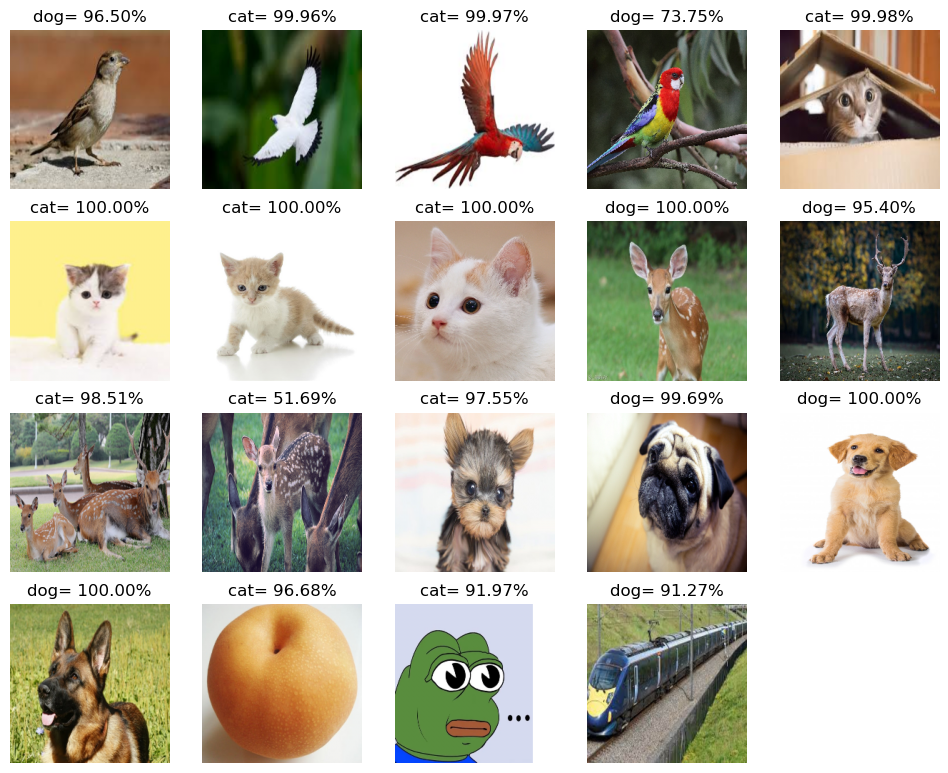

In [80]:
plt.figure(figsize=(12, 12))

for i in range(len(pred)):
    if pred[i] > 0.5:
        prob = pred[i]
        prediction = "dog"
    else:
        prob = 1.0 - pred[i]
        prediction = "cat"
    
    
    plt.subplot(5,5, i+1)
    plt.axis("off")
    
    prob_str = str("{0:0.2f}".format(100*max(prob))) + "%"
    plt.imshow(test_img_list[i])
    plt.title(prediction + "= " + prob_str)

### 2. categorical

In [81]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

train_data_gen = ImageDataGenerator(rotation_range=10,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    rescale = 1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1)

# test_data에는 정규화만 적용해준다
test_data_gen = ImageDataGenerator(rescale = 1./255)

train_dir = "content/cats_and_dogs_filtered/train"
test_dir = "content/cats_and_dogs_filtered/validation"

train_data = gen.flow_from_directory(directory=train_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "categorical")

test_data = gen.flow_from_directory(directory=test_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "categorical")

print(train_data.class_indices)
print(train_data.num_classes)


print(test_data.class_indices)
print(test_data.num_classes)




base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3))

# include_top = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation="softmax"))

model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), metrics=['acc'])


start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=16, validation_data=test_data)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

model.evaluate(test_data)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 50176)             0         
                                                                 
 dense_34 (Dense)            (None, 16)                802832    
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                 34        
                                                   

[0.08937029540538788, 0.9570000171661377]

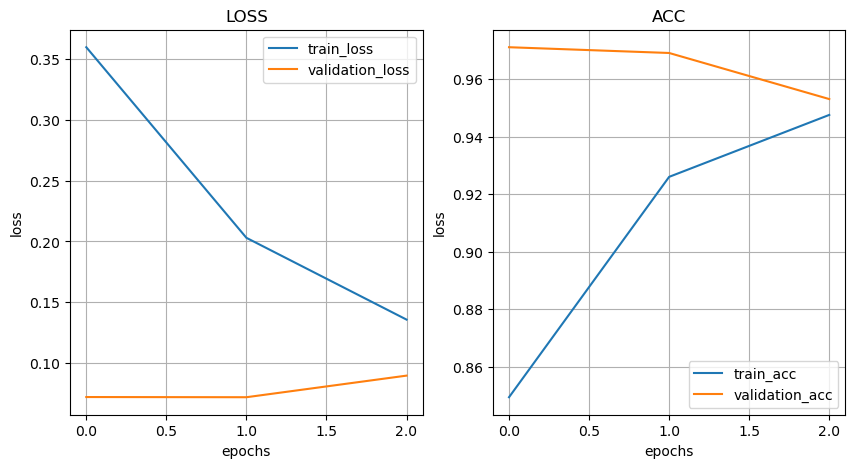

In [82]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [83]:
test_img_list = []

test_img_name_list = glob.glob("data/test_dir/*")

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=[IMAGE_WIDTH, IMAGE_HEIGHT])
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img/255.0
    test_img_list.append(dst_img)
    
print(test_img_list)

[array([[[0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        ...,
        [0.55294118, 0.43921569, 0.28235294],
        [0.56078431, 0.43921569, 0.28627451],
        [0.56470588, 0.43921569, 0.28627451]],

       [[0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        ...,
        [0.55294118, 0.43529412, 0.28235294],
        [0.56078431, 0.43529412, 0.28235294],
        [0.56470588, 0.43137255, 0.28235294]],

       [[0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        ...,
        [0.55294118, 0.43137255, 0.27843137],
        [0.56078431, 0.43137255, 0.27843137],
        [0.56470588, 0.42745098, 0.27843137]],

       ...,

       [[0.80392157, 0.78039216, 0.73333333],
        [0.78431373, 0.76078431, 0.71372549],
        [0.75294118, 

In [84]:
pred = model.predict(np.array(test_img_list))
print(pred.shape)
print(pred)

1/1 [==============================] - 0s 422ms/step
(19, 2)
[[1.9529760e-02 9.8047024e-01]
 [8.9746433e-01 1.0253573e-01]
 [8.6100125e-01 1.3899875e-01]
 [2.5610600e-02 9.7438937e-01]
 [9.6890497e-01 3.1095006e-02]
 [9.9998152e-01 1.8516628e-05]
 [9.9999917e-01 7.7948806e-07]
 [9.9749655e-01 2.5034298e-03]
 [6.9343960e-01 3.0656040e-01]
 [1.7742097e-03 9.9822575e-01]
 [8.3961391e-01 1.6038604e-01]
 [5.7666773e-01 4.2333230e-01]
 [5.7508808e-02 9.4249117e-01]
 [4.5691123e-03 9.9543095e-01]
 [2.5435096e-10 1.0000000e+00]
 [1.0780488e-03 9.9892199e-01]
 [8.6350811e-01 1.3649191e-01]
 [3.5945758e-01 6.4054233e-01]
 [4.5251560e-01 5.4748440e-01]]


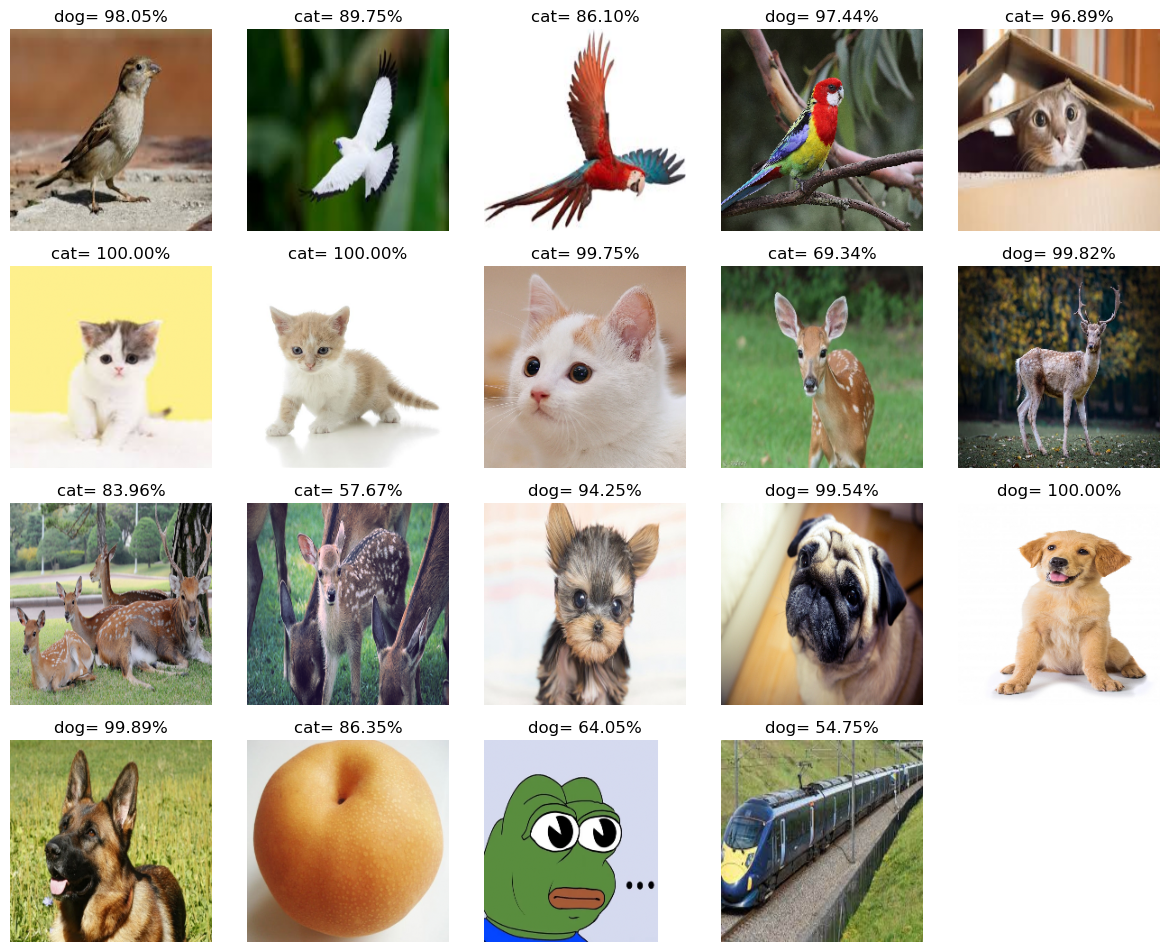

In [85]:
plt.figure(figsize=(12, 12))

class_name = ["cat", "dog"]

for i in range(len(pred)):

    plt.subplot(5,5, i+1)
    plt.axis("off")
    
    prob = 1 - pred[i]
    prediction = class_name[np.argmax(pred[i])]
    prob_str = str("{0:0.2f}".format(100*max(prob))) + "%"
    plt.imshow(test_img_list[i])
    plt.title(prediction + "= " + prob_str)

plt.tight_layout()

# 3. sparse categorical

In [86]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

train_data_gen = ImageDataGenerator(rotation_range=10,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    rescale = 1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1)

# test_data에는 정규화만 적용해준다
test_data_gen = ImageDataGenerator(rescale = 1./255)

train_dir = "content/cats_and_dogs_filtered/train"
test_dir = "content/cats_and_dogs_filtered/validation"

train_data = gen.flow_from_directory(directory=train_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "sparse")

test_data = gen.flow_from_directory(directory=test_dir, batch_size=4,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "sparse")

print(train_data.class_indices)
print(train_data.num_classes)


print(test_data.class_indices)
print(test_data.num_classes)




base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3))

# include_top = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation="softmax"))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), metrics=['acc'])


start_time = datetime.now()

result = model.fit(train_data, epochs=3, batch_size=16, validation_data=test_data)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

model.evaluate(test_data)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 50176)             0         
                                                                 
 dense_36 (Dense)            (None, 16)                802832    
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_37 (Dense)            (None, 2)                 34        
                                                   

[0.10326333343982697, 0.9559999704360962]

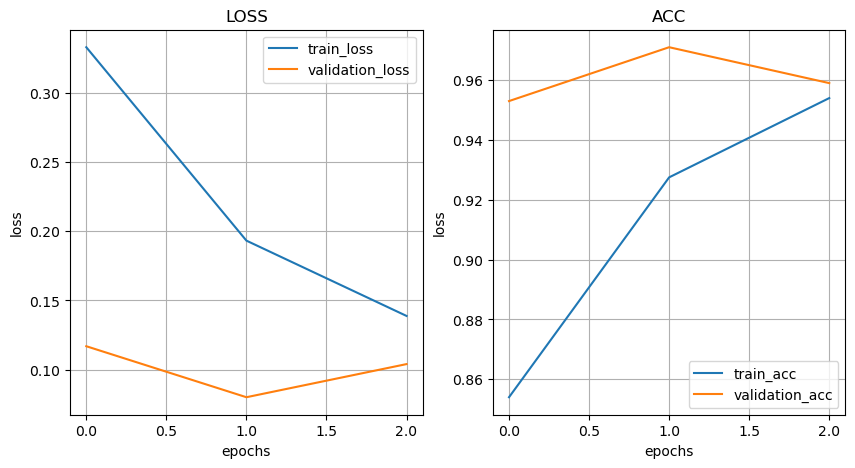

In [87]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [88]:
test_img_list = []

test_img_name_list = glob.glob("data/test_dir/*")

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=[IMAGE_WIDTH, IMAGE_HEIGHT])
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img/255.0
    test_img_list.append(dst_img)
    
print(test_img_list)

[array([[[0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        ...,
        [0.55294118, 0.43921569, 0.28235294],
        [0.56078431, 0.43921569, 0.28627451],
        [0.56470588, 0.43921569, 0.28627451]],

       [[0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        ...,
        [0.55294118, 0.43529412, 0.28235294],
        [0.56078431, 0.43529412, 0.28235294],
        [0.56470588, 0.43137255, 0.28235294]],

       [[0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        ...,
        [0.55294118, 0.43137255, 0.27843137],
        [0.56078431, 0.43137255, 0.27843137],
        [0.56470588, 0.42745098, 0.27843137]],

       ...,

       [[0.80392157, 0.78039216, 0.73333333],
        [0.78431373, 0.76078431, 0.71372549],
        [0.75294118, 

In [89]:
pred = model.predict(np.array(test_img_list))
print(pred.shape)
print(pred)

1/1 [==============================] - 0s 406ms/step
(19, 2)
[[4.72229440e-03 9.95277762e-01]
 [9.57684100e-01 4.23159152e-02]
 [8.79349291e-01 1.20650664e-01]
 [5.30505693e-03 9.94695008e-01]
 [9.99953508e-01 4.65417288e-05]
 [1.00000000e+00 2.67602451e-09]
 [1.00000000e+00 1.23782256e-08]
 [1.00000000e+00 2.06351780e-09]
 [4.52188216e-02 9.54781175e-01]
 [1.47876097e-03 9.98521268e-01]
 [5.19184828e-01 4.80815232e-01]
 [1.92573413e-01 8.07426572e-01]
 [9.95154500e-01 4.84555913e-03]
 [4.77753207e-03 9.95222509e-01]
 [9.75959265e-05 9.99902368e-01]
 [1.49730993e-02 9.85026896e-01]
 [9.72383559e-01 2.76164059e-02]
 [9.64334309e-01 3.56656909e-02]
 [2.40274966e-02 9.75972533e-01]]


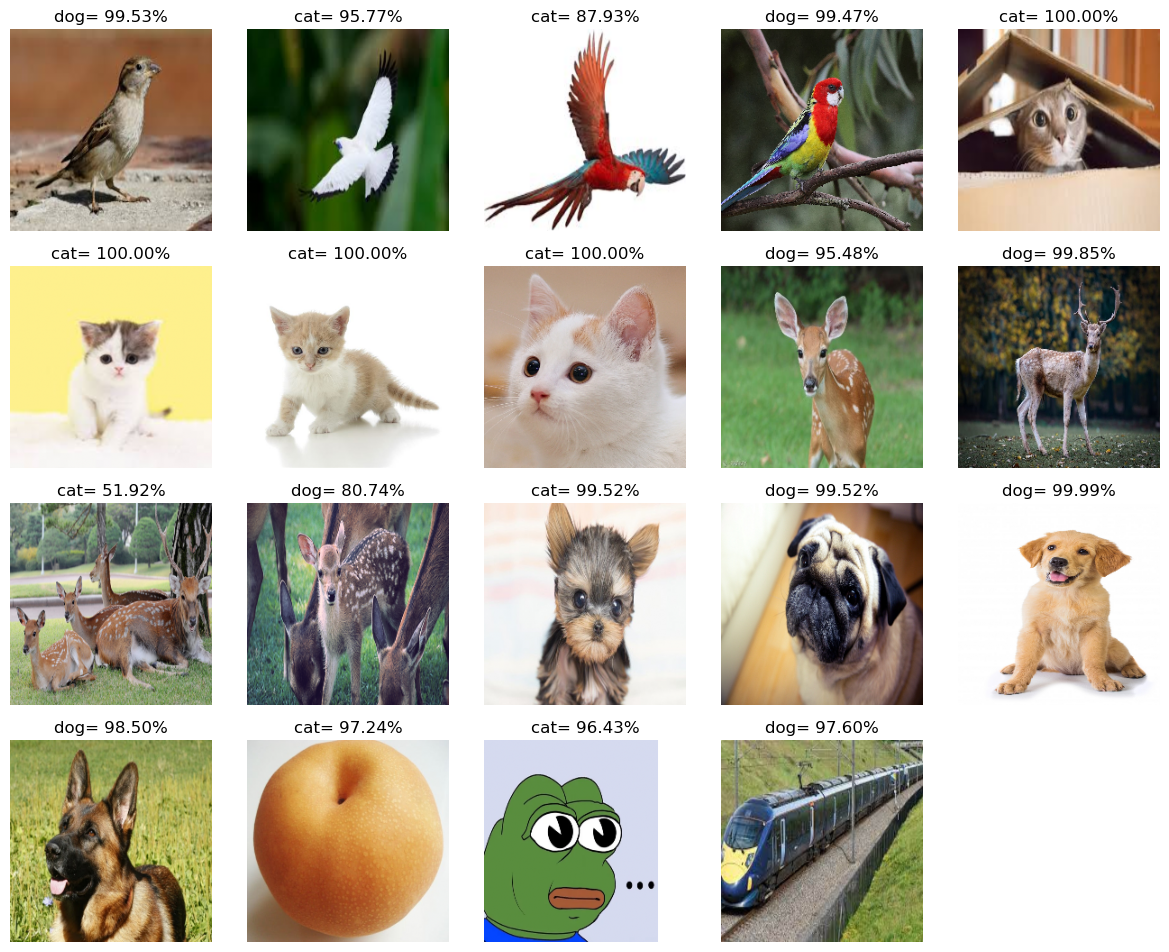

In [90]:
plt.figure(figsize=(12, 12))

class_name = ["cat", "dog"]

for i in range(len(pred)):

    plt.subplot(5,5, i+1)
    plt.axis("off")
    
    prob = 1 - pred[i]
    prediction = class_name[np.argmax(pred[i])]
    prob_str = str("{0:0.2f}".format(100*max(prob))) + "%"
    plt.imshow(test_img_list[i])
    plt.title(prediction + "= " + prob_str)

plt.tight_layout()

In [14]:
?ImageDateGenerator

Object `ImageDateGenerator` not found.


In [2]:
#밑에 train_data = train_data_gen.flow로 고친거 위에도 수정하기

# 4. Validation Split

In [18]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

# 훈련용에서 따로 validation data를 빼고자 한자면  ImageDataGenerator(validation_split을 사용해야 편하다)
# validation_split 최소 10%이상이 기본. default = 0.0
train_data_gen = ImageDataGenerator(rotation_range=10,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    rescale = 1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   validation_split=0.2)

# test_data에는 정규화만 적용해준다
test_data_gen = ImageDataGenerator(rescale = 1./255)


# train_data_gen에서 validation_split을 지정했다면, val_data_gen에서도 같은 수치로 지정해야함
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = "content/cats_and_dogs_filtered/train"
test_dir = "content/cats_and_dogs_filtered/validation"

train_data = train_data_gen.flow_from_directory(directory=train_dir, batch_size=32,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "binary", subset="training")

test_data = test_data_gen.flow_from_directory(directory=test_dir, batch_size=32,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "binary")

# val_data_gen을 만들었으니 그것을 받는 val_data도 만든다.
val_data = val_data_gen.flow_from_directory(directory=train_dir, batch_size=32,
                        shuffle=True,target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                       class_mode = "binary", subset="validation")



print(train_data.class_indices)
print(train_data.num_classes)


print(test_data.class_indices)
print(test_data.num_classes)




base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH, 3))

# include_top = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(loss="binary_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), metrics=['accuracy'])


start_time = datetime.now()

# validation_dat = val_data
result = model.fit(train_data, epochs=3, batch_size=16, validation_data=val_data)

end_time = datetime.now()
print("\n걸린시간 : ", end_time - start_time)

model.evaluate(test_data)

Found 1600 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
2
{'cats': 0, 'dogs': 1}
2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                802832    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
           

[0.0464167520403862, 0.9819999933242798]

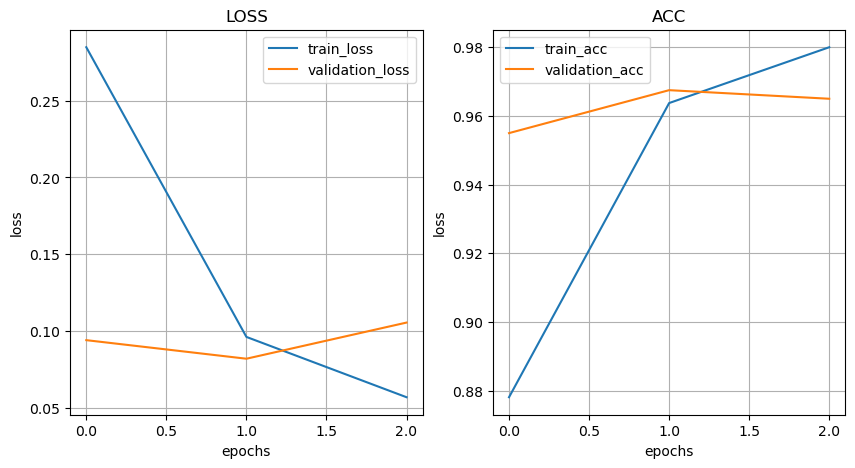

In [21]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label="train_acc")
plt.plot(result.history["val_accuracy"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [22]:
test_img_list = []

test_img_name_list = glob.glob("data/test_dir/*")

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=[IMAGE_WIDTH, IMAGE_HEIGHT])
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img/255.0
    test_img_list.append(dst_img)
    
print(test_img_list)

[array([[[0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        [0.61960784, 0.4627451 , 0.3254902 ],
        ...,
        [0.55294118, 0.43921569, 0.28235294],
        [0.56078431, 0.43921569, 0.28627451],
        [0.56470588, 0.43921569, 0.28627451]],

       [[0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        [0.61568627, 0.45882353, 0.32156863],
        ...,
        [0.55294118, 0.43529412, 0.28235294],
        [0.56078431, 0.43529412, 0.28235294],
        [0.56470588, 0.43137255, 0.28235294]],

       [[0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        [0.61568627, 0.45490196, 0.31764706],
        ...,
        [0.55294118, 0.43137255, 0.27843137],
        [0.56078431, 0.43137255, 0.27843137],
        [0.56470588, 0.42745098, 0.27843137]],

       ...,

       [[0.80392157, 0.78039216, 0.73333333],
        [0.78431373, 0.76078431, 0.71372549],
        [0.75294118, 

In [23]:
pred = model.predict(np.array(test_img_list))
print(pred.shape)
print(pred)

1/1 [==============================] - 0s 422ms/step
(19, 1)
[[9.9999225e-01]
 [5.0566811e-02]
 [1.1149880e-01]
 [9.9889266e-01]
 [1.2925228e-04]
 [6.6669791e-08]
 [2.7153465e-07]
 [6.4824706e-09]
 [9.9985296e-01]
 [9.7719622e-01]
 [8.8604033e-01]
 [9.9850333e-01]
 [8.4512877e-01]
 [9.9940795e-01]
 [9.9999517e-01]
 [9.9999839e-01]
 [3.6391357e-01]
 [8.4588432e-01]
 [9.9970657e-01]]


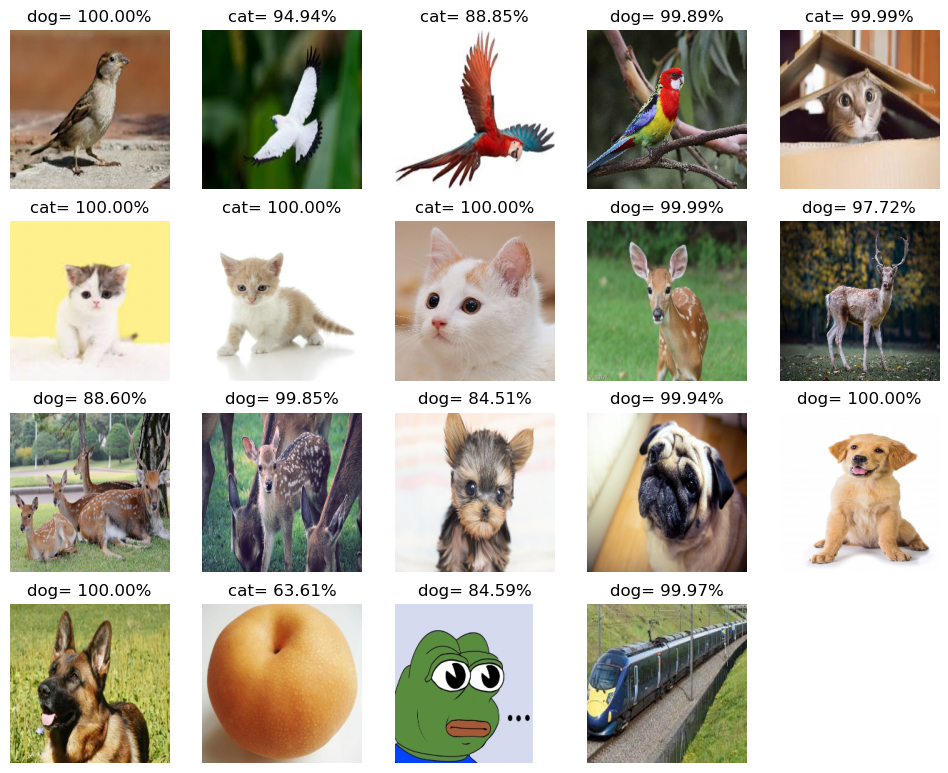

In [25]:
plt.figure(figsize=(12, 12))

for i in range(len(pred)):
    if pred[i] > 0.5:
        prob = pred[i]
        prediction = "dog"
    else:
        prob = 1.0 - pred[i]
        prediction = "cat"
    
    
    plt.subplot(5,5, i+1)
    plt.axis("off")
    
    prob_str = str("{0:0.2f}".format(100*max(prob))) + "%"
    plt.imshow(test_img_list[i])
    plt.title(prediction + "= " + prob_str)